In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
try:
    from eda import ExplanatoryAnalysis
except:
    print("import error")

In [3]:
df_bnd = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\BND_raw_data.csv')
df_spy = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\SPY_raw_data.csv')
df_tsla = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\TSLA_raw_data.csv')

In [4]:
bnd_eda = ExplanatoryAnalysis()
spy_eda = ExplanatoryAnalysis()
tsla_eda = ExplanatoryAnalysis()

In [5]:
df_bnd=bnd_eda.to_time(df_bnd, "BND")
df_spy=spy_eda.to_time(df_spy, "SPY")
df_tsla=tsla_eda.to_time(df_tsla, "TSLA")

In [6]:
df_tsla.head()

,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
adf_test = adfuller(df_tsla["Close_TSLA"].dropna())
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -0.5687280656291531, p-value: 0.8778928052253298


In [7]:
train_size = int(0.8* len(df_tsla))
train_size

2028

In [8]:
df_tsla['Close_TSLA_Diff'] = df_tsla['Close_TSLA'].diff().dropna()
last_close = df_tsla['Close_TSLA'][train_size-1]

C:\Users\Aman\AppData\Local\Temp\ipykernel_12456\1861493119.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_close = df_tsla['Close_TSLA'][train_size-1]


In [9]:
# Train ARIMA on the differenced series
train_data = df_tsla["Close_TSLA_Diff"][:train_size]
test_data = df_tsla[["Close_TSLA"]][train_size:train_size+30]

In [106]:

arima_model = ARIMA(train_data, order=(2,1,2))  # d=1 since we differenced once
arima_result = arima_model.fit()

c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 

In [107]:
# Forecast next 30 days
forecast_diff = arima_result.forecast(steps=30)
# Get last actual price before forecasting
last_actual_price = last_close  

# Convert differenced predictions back to original scale
forecast_actual = last_actual_price + forecast_diff.cumsum()


c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


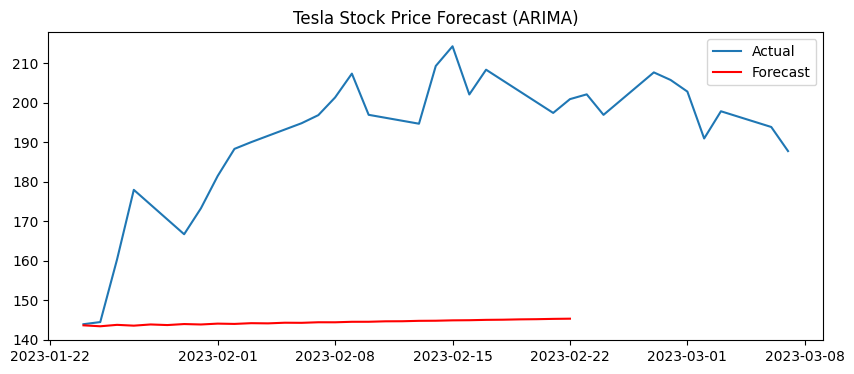

In [108]:

plt.figure(figsize=(10,4))
plt.plot(test_data.index, test_data["Close_TSLA"], label="Actual")
plt.plot(pd.date_range(test_data.index[0], periods=30, freq="D"), forecast_actual, label="Forecast", color="red")
plt.legend()
plt.title("Tesla Stock Price Forecast (ARIMA)")
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Select closing price & normalize it
scaler = MinMaxScaler(feature_range=(0,1))
df_tsla["Close_scaled"] = scaler.fit_transform(df_tsla[["Close_TSLA"]])

# Define lookback period (e.g., 60 days)
timesteps = 60  

# Prepare training data
X_train, y_train = [], []
for i in range(timesteps, len(df_tsla) - 30):  # Reserve last 30 days for forecasting
    X_train.append(df_tsla["Close_scaled"].values[i-timesteps:i])
    y_train.append(df_tsla["Close_scaled"].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)




In [113]:
# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  
    Dropout(0.2),  
    LSTM(units=50, return_sequences=True),
    Dropout(0.1),
    LSTM(units=50, return_sequences=False),
    Dropout(0.1),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.0263
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0021
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0021
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0015
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0015
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0015
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0012
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0012
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0012
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0012
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0011
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 9.3494e-04
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 9.2636e-04
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 8.5983e-04
Epoch 15/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 8.5128e

In [ ]:
# Prepare test data (last `timesteps` days)
test_df = df_tsla["Close_scaled"].values[-timesteps:].reshape(1, timesteps, 1)


In [96]:
x_test =test_df[0,:,]
y_test =df_tsla["Close_scaled"][-60:].values

In [114]:
loss = model.evaluate(x_test, y_test)
loss = scaler.inverse_transform([[loss]])
loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0898


array([[54.34601847]])

In [115]:
preds = model.predict(test_df[0,:,])
preds = scaler.inverse_transform(preds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


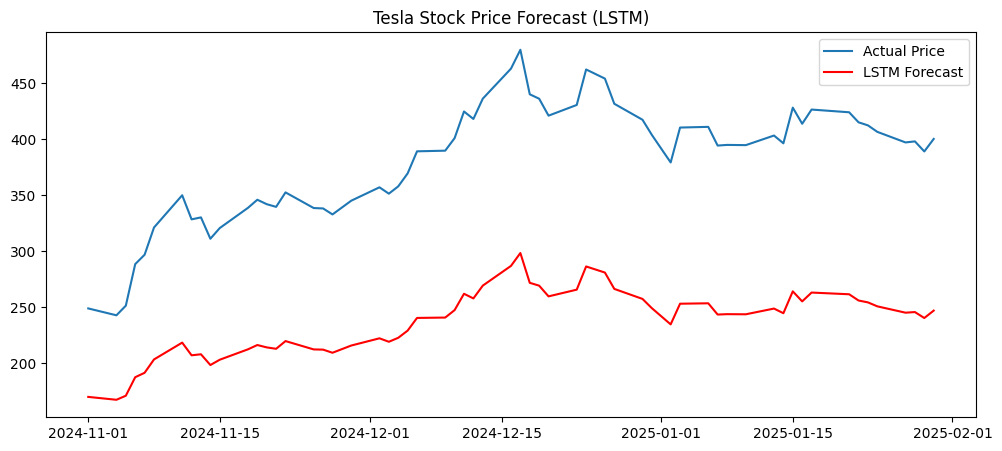

In [116]:
# Plot forecast vs actual data
plt.figure(figsize=(12,5))
plt.plot(df_tsla.index[-60:], df_tsla["Close_TSLA"].values[-60:], label="Actual Price")
plt.plot(df_tsla["Close_TSLA"][-60:].index,preds, label="LSTM Forecast", color="red")
plt.legend()
plt.title("Tesla Stock Price Forecast (LSTM)")
plt.show()

In [14]:
# Check if model is trainable
print("Is model trainable?", model.trainable)

# Check model input shape
print("Expected input shape:", model.input_shape)

# Check if the model has been trained by evaluating on a subset
sample_x = X_train[:5]  # Take first 5 samples from training set
sample_y = y_train[:5]

loss = model.evaluate(sample_x, sample_y)
print("Loss on sample data:", loss)


Is model trainable? True
Expected input shape: (None, 60, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 1.1173e-04
Loss on sample data: 0.00011172556696692482


In [17]:
print("Test Data Shape:", test_df.shape)  # Should be (1, 60, 1)
print("Test Data Type:", test_df.dtype)  # Should be float32


Test Data Shape: (1, 60, 1)
Test Data Type: float64


In [18]:
test_df = test_df.astype(np.float32)


In [ ]:
sample_input = X_train[:2]  # Take one known training input
print("Sample Input Shape:", sample_input.shape)  # Should be (1, 60, 1)

sample_pred = model.predict(sample_input)
print("Prediction on Training Sample:", sample_pred)


Sample Input Shape: (1, 60)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Prediction on Training Sample: [[0.01844101]]


In [24]:
test_df

array([[[0.5090605 ],
        [0.49600452],
        [0.51429147],
        [0.593159  ],
        [0.6109781 ],
        [0.6626705 ],
        [0.72386783],
        [0.6781293 ],
        [0.6818505 ],
        [0.6413216 ],
        [0.6616073 ],
        [0.6999247 ],
        [0.7153623 ],
        [0.70692056],
        [0.70183855],
        [0.72931135],
        [0.69960576],
        [0.6988403 ],
        [0.68748546],
        [0.71357614],
        [0.7389439 ],
        [0.72688735],
        [0.74073005],
        [0.765311  ],
        [0.8072646 ],
        [0.8084767 ],
        [0.83229214],
        [0.8828575 ],
        [0.8686746 ],
        [0.9072259 ],
        [0.9641917 ],
        [1.        ],
        [0.9155188 ],
        [0.90709835],
        [0.87496865],
        [0.8952544 ],
        [0.9626182 ],
        [0.9452882 ],
        [0.8975083 ],
        [0.86720735],
        [0.8383523 ],
        [0.78612834],
        [0.8523865 ],
        [0.85368353],
        [0.8181942 ],
        [0

In [30]:
pred = model.predict(test_df[0])
print(pred[0,0])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0.3571183
